<a href="https://colab.research.google.com/github/shubhamringole/ComputerVisionDeeplearning/blob/main/GradCAM%2CGradCam%2B%2B%26_Faster_ScoreCAM_Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GradCAm,GradCAM++ and Faster-ScoreCAM**

By Shubham Ingole

In this lesson, we will use Keras with Tensorflow2.0 to visualise the following(see below).This helps you to gain a better understanding of what's going on under the Hood and de-mystifies some of the deep learning aspects

- 1. Learn to use the GradCAM,GradCAM++,ScoreCAM and Faster-ScoreCAM to see where our CNN is looking

# Install Libraries
Firstyl, we need to installtf-keras-vis

In [1]:
pip install --upgrade tf-keras-vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 786 kB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 6.0 MB 60.5 MB/s 
     |████████████████████████████████| 439 kB 65.0 MB/s 
     |████████████████████████████████| 1.7 MB 73.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12

# **Load our libraries**

In [2]:
%reload_ext autoreload
%autoreload 2 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


# Load a Pretrained VGG16 Model

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as model

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

#load_model

model = model(weights='imagenet',include_top=True)
model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# Load Images
tf-keras-vis support evaluating batch wisely that include multiple images.Here, we load three pictures of goldfish, bear and assult rifle as inputs data.

In [4]:
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/bear.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/soldiers.jpg

--2022-12-22 06:29:48--  https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg [following]
--2022-12-22 06:29:48--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg’

goldfish.jpg        100%[===================>]   8.63K  --.-KB/s    in 0s      

2022-12-22 06:29:48 (83.5 MB/s) - ‘goldfish.jpg’ saved [8833/8833]


##  let's visualize the images

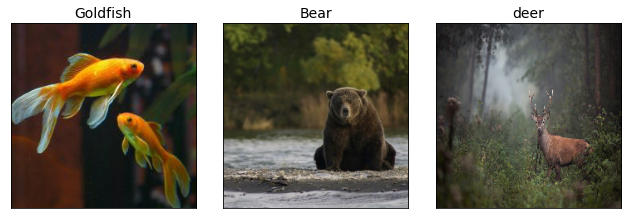

In [12]:
from matplotlib import image
from tensorflow.keras.preprocessing.image import load_img

#image titles
image_titles = ['Goldfish','Bear','deer']

#load Images
img1 = load_img('goldfish.jpg',target_size=(224,224))
img2= load_img('bear.jpg',target_size=(224,224))
img3= load_img('deer.jpg',target_size=(224,224))
images = np.asarray([np.array(img1),np.array(img2),np.array(img3)])
#preparing input data
X = preprocess_input(images)

#rendering
subplot_args = {'nrows':1,'ncols':3,'figsize':(9,3),
                'subplot_kw':{'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
  ax[i].set_title(title,fontsize=14)
  ax[i].imshow(images[i])
plt.tight_layout()
plt.show()



## **Define necessary functions** 

#### **Define Loss functions** 

You MUST define loss function that return target scores. Here, it returns the scores corresponding Goldfish, Bear, Assault Rifle.

In [6]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][1], output[1][294], output[2][413])

#### **Define Model-Modifier function**

Then, when the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you need to replace the function to a linear function. Here, we does so using model_modifier.



In [7]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

## **GradCAM**

GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

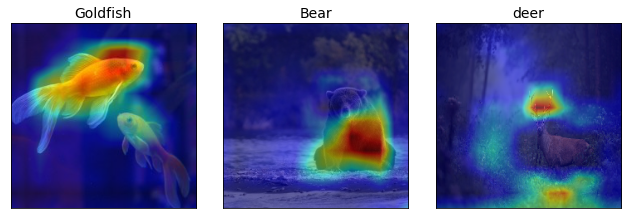

CPU times: user 393 ms, sys: 106 ms, total: 499 ms
Wall time: 414 ms


In [13]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

## **GradCAM++**

GradCAM++ can provide better visual explanations of CNN model predictions. In tf-keras-vis, GradcamPlusPlus (GradCAM++) class has most of compatibility with Gradcam. So you can use GradcamPlusPlus if you just replace classname from Gradcam to GradcamPlusPlus.



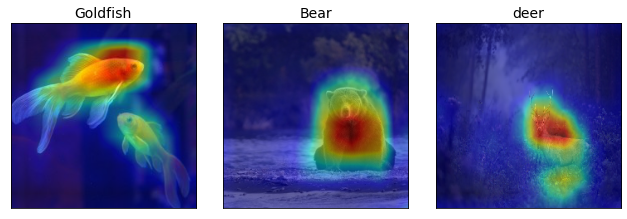

CPU times: user 395 ms, sys: 111 ms, total: 506 ms
Wall time: 406 ms


In [14]:
%%time

from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object, Just only repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM++
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

As you can see above, Now, the visualized attentions almost completely cover the target objects!

## **ScoreCAM**

Lastly, Here, we show you ScoreCAM. SocreCAM is an another method that generate Class Activation Map. The characteristic is that it's the gradient-free CAM method unlike GradCAM/GradCAM++.

In default, this method takes too much time, so in the cell below ScoreCAM is NOT run with CPU.



48/48 [==============================] - 5s 111ms/step


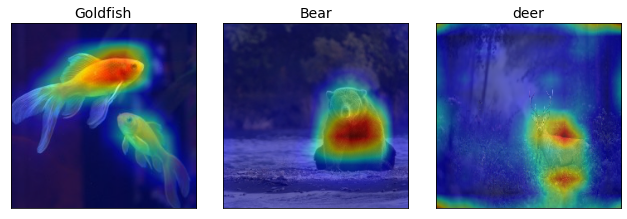

CPU times: user 18.7 s, sys: 2.12 s, total: 20.8 s
Wall time: 24.6 s


In [15]:
%%time

from tf_keras_vis.scorecam import ScoreCAM

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# This cell takes toooooooo much time, so only doing with GPU.
if gpus > 0:
    # Generate heatmap with ScoreCAM
    cam = scorecam(loss,
                   X,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("NOTE: Change to GPU to see visual output\n")


##**Faster-ScoreCAM**

As you see above, ScoreCAM need huge processing power, but there is a good news for us. Faster-ScorecAM that makes ScoreCAM to be more efficient was devised by @tabayashi0117.

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam

> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).

3/3 [==============================] - 5s 2s/step


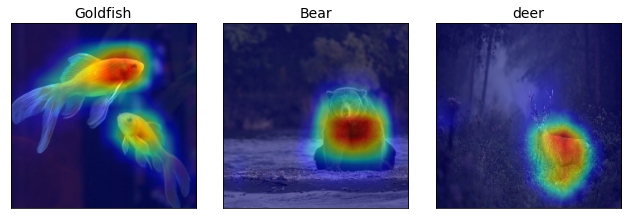

CPU times: user 5.53 s, sys: 132 ms, total: 5.66 s
Wall time: 5.74 s


In [16]:
%%time

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               X,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()